In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import re
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [41]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [42]:
def plot_xp_regions(experiments : list, regions : list, colors : list = None, ncols: int = 3):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
            if len(colors) > 0: li.set_color(colors[c])
            ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

In [142]:
asf = dict({'C1s' : 0.296, 'O1s' : 0.711, 'N1s' : 0.477, 'Si2p' : 0.339,
            'Ba3d' : 7.49,'Au4f' : 6.250, 'Cl2p' : 0.891})

In [178]:
pathfile = '/Users/pabloherrero/sabat/xps_spectra/ITO_untreated.itx'
def itx_import(path : str, name: str, label: str) -> XPS_experiment:
    with open(path) as fin:
        lines = fin.readlines()
        EE, SS = [], []
        KE = []
        names = []
        counts = []    # skiplines = []
        pattern = r"'([A-Za-z0-9_\./\\-\\ ]*)'"
        npoints = []
        for i,l in enumerate(lines):
            if 'SetScale/I x' in l:
                KE.append(l[16:-1])  # This all could be regex...
            if 'Scan Step' in l:
                SS.append(float(l[24:-1]))
            if 'WAVES/S/N' in l:
                npoints.append(int(re.findall(r'\((\d+)\)', l)[0]))
                names.append(re.findall(pattern, l)[0])
            if 'Excitation Energy' in l:
                EE.append(float(l[24:-1]))
            if 'BEGIN' in l:
                counts.append(pd.Series(list(map(float, lines[i+1].split()))))
#                 skiplines.append(i)
                

    frames = []
    for i, c in enumerate(counts):
#         counts = pd.Series(pd.read_table(pathfile, sep='\s+', skiprows=skiplines[i]+1, nrows=1).T.index)
        ke0, kef = re.findall('\d+\.\d+', KE[i])
        kenergy = np.linspace(float(ke0), float(kef)+SS[i], num=npoints[i])
        bindenergy = EE[i] - kenergy
        assert len(bindenergy) == len(c), "Import error: xy lengths do not coincide"
        region = pd.DataFrame({'energy': bindenergy, 'counts':c})
        frames.append(region)

    dfx = pd.concat(frames, axis=1)
    mi = pd.MultiIndex.from_product([names, np.array(['energy', 'counts'])], names=['range', 'properties'])
    
    mi.to_frame()
    dfx.columns = mi
    dfx.index.name=None


    return XPS_experiment(path = path, dfx = dfx, name= name, label=label)

XPS_experiment(path='/Users/pabloherrero/sabat/xps_spectra/ITO_untreated.itx', delimiters=None, name='untreated', label='Untreated ITO', date=None, other_meta=None, dfx=range       1_overview                2_O1s                3_C1s           \
properties       energy  counts      energy   counts      energy   counts   
0           1200.000000  7697.5  552.000000  2252.67  305.000000  841.333   
1           1198.999169  7582.5  551.899677  2238.93  304.899677  823.200   
2           1197.998339  7560.0  551.799355  2255.20  304.799355  843.600   
3           1196.997508  7565.0  551.699032  2247.47  304.699032  834.667   
4           1195.996678  7700.0  551.598710  2271.47  304.598710  849.867   
5           1194.995847  7445.0  551.498387  2265.87  304.498387  830.000   
6           1193.995017  7830.0  551.398065  2253.33  304.398065  841.067   
7           1192.994186  7655.0  551.297742  2245.73  304.297742  840.667   
8           1191.993355  7360.0  551.197419  2262.00  304.197

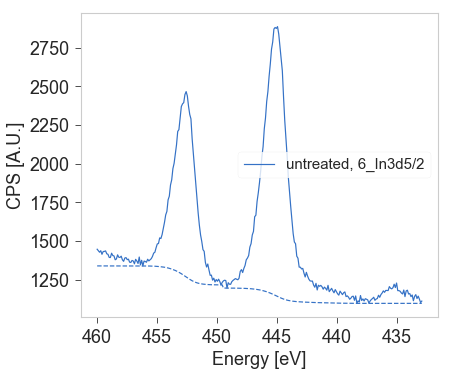

In [183]:
region = '6_In3d5/2'
xp = itx_import(pathfile, name='untreated', label='Untreated ITO')
# xp.dfx[region].energy
subtract_double_shirley(xp, region, xlim=449.5)

# FBI silica + Ba(ClO4)2
40, 80 and 120 pulses

At $t_{on}$ = 50 ms and C = 1µM

## Import data

In [6]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_silica_pellet/20191213_Silica_pellet_FBI.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)
for f in files:
    print(f)
#     print(os.path.split(f)[1])

/Users/pabloherrero/sabat/xps_spectra/FBI_silica_pellet/20191213_Silica_pellet_FBI.xy


In [7]:
names = ['silica_pellet_FBI']
label = ['FBI pellet sample']

experiments = [xps_data_import(path=f, name=n, label=l) for f,n,l in zip(files, names, label)]
experiments[0].name

'silica_pellet_FBI'

In [8]:
experiments[0].dfx

range          overview_           O1s             C1s           Si2p          \
properties        energy counts energy   counts energy  counts energy  counts   
0           1.200000e+03  36130  537.0  46957.0  305.0  2633.8  120.0  1476.8   
1           1.199000e+03  36220  536.9  50049.0  304.9  2710.4  119.9  1443.6   
2           1.198000e+03  36155  536.8  53069.0  304.8  2633.0  119.8  1404.8   
3           1.197000e+03  34960  536.7  55878.0  304.7  2665.8  119.7  1452.4   
4           1.196000e+03  35420  536.6  57994.0  304.6  2640.6  119.6  1433.6   
5           1.195000e+03  35415  536.5  60706.0  304.5  2663.6  119.5  1419.6   
6           1.194000e+03  35545  536.4  61686.0  304.4  2611.6  119.4  1393.6   
7           1.193000e+03  35545  536.3  62381.0  304.3  2629.0  119.3  1396.0   
8           1.192000e+03  35810  536.2  62992.0  304.2  2607.2  119.2  1390.4   
9           1.191000e+03  35170  536.1  62283.0  304.1  2686.2  119.1  1411.6   
10          1.190000e+03  35120  536.0  61646.0  304.0  2657.4  119.0  1379.2   
11          1.189000e+03  34840  535.9  60141.0  303.9  2641.0  118.9  1364.4   
12          1.188000e+03  35160  535.8  58198.0  303.8  2638.0  118.8  1366.8   
13          1.187000e+03  35615  535.7  55561.0  303.7  2628.6  118.7  1317.2   
14          1.186000e+03  35255  535.6  52355.0  303.6  2646.2  118.6  1326.8   
15          1.185000e+03  34650  535.5  49113.0  303.5  2622.4  118.5  1342.8   
16          1.184000e+03  34490  535.4  45971.0  303.4  2635.4  118.4  1353.2   
17          1.183000e+03  33845  535.3  42194.0  303.3  2610.0  118.3  1309.2   
18          1.182000e+03  34495  535.2  38327.0  303.2  2630.0  118.2  1330.4   
19          1.181000e+03  34755  535.1  35144.0  303.1  2603.6  118.1  1278.4   
20          1.180000e+03  34180  535.0  31972.0  303.0  2655.2  118.0  1252.0   
21          1.179000e+03  34390  534.9  28811.0  302.9  2632.2  117.9  1244.8   
22          1.178000e+03  34385  534.8  25792.0  302.8  2589.4  117.8  1270.8   
23          1.177000e+03  33995  534.7  22826.0  302.7  2644.6  117.7  1221.2   
24          1.176000e+03  34435  534.6  20528.0  302.6  2611.2  117.6  1236.4   
25          1.175000e+03  34675  534.5  18635.0  302.5  2638.8  117.5  1256.4   
26          1.174000e+03  34045  534.4  17024.0  302.4  2641.6  117.4  1213.2   
27          1.173000e+03  34735  534.3  14925.0  302.3  2618.6  117.3  1230.0   
28          1.172000e+03  33995  534.2  13624.0  302.2  2576.2  117.2  1182.0   
29          1.171000e+03  33885  534.1  12381.0  302.1  2635.0  117.1  1144.0   
...                  ...    ...    ...      ...    ...     ...    ...     ...   
1175        2.500000e+01   1450    NaN      NaN    NaN     NaN    NaN     NaN   
1176        2.400000e+01   1470    NaN      NaN    NaN     NaN    NaN     NaN   
1177        2.300000e+01   1480    NaN      NaN    NaN     NaN    NaN     NaN   
1178        2.200000e+01   1490    NaN      NaN    NaN     NaN    NaN     NaN   
1179        2.100000e+01   1450    NaN      NaN    NaN     NaN    NaN     NaN   
1180        2.000000e+01   1670    NaN      NaN    NaN     NaN    NaN     NaN   
1181        1.900000e+01   2155    NaN      NaN    NaN     NaN    NaN     NaN   
1182        1.800000e+01   2150    NaN      NaN    NaN     NaN    NaN     NaN   
1183        1.700000e+01   2210    NaN      NaN    NaN     NaN    NaN     NaN   
1184        1.600000e+01   1905    NaN      NaN    NaN     NaN    NaN     NaN   
1185        1.500000e+01   1890    NaN      NaN    NaN     NaN    NaN     NaN   
1186        1.400000e+01   1690    NaN      NaN    NaN     NaN    NaN     NaN   
1187        1.300000e+01   1560    NaN      NaN    NaN     NaN    NaN     NaN   
1188        1.200000e+01   1915    NaN      NaN    NaN     NaN    NaN     NaN   
1189        1.100000e+01   1875    NaN      NaN    NaN     NaN    NaN     NaN   
1190        1.000000e+01   1920    NaN      NaN    NaN     NaN    NaN     NaN   
1191        9.000000e+00   1460

## Shift -2 eV

In [9]:
experiments[0] = align_dfx(experiments[0], shift = -2.)

## Bg subtraction

Text(0.5, 1.0, 'Silica pellet overview')

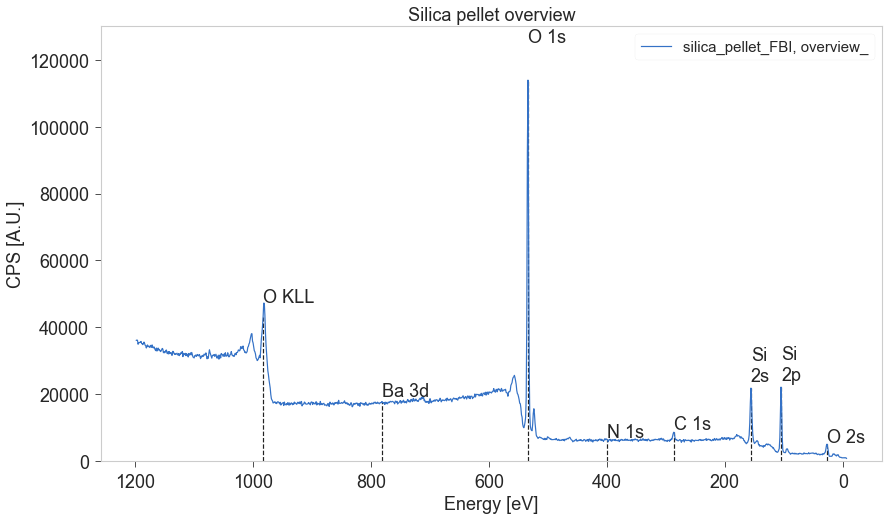

In [39]:
region = 'overview_'

plt.figure(figsize=(14,8))
for xp in experiments:
    plot_region(xp, 'overview_')
# plt.xlim(520, 560)
# plt.ylim(1.5e5, 4e5)
# cosmetics_plot()
peakLb = ['O KLL', 'Ba 3d', 'O 1s', 'N 1s', 'C 1s', 'Si\n2s', 'Si\n2p', 'O 2s']
peakEn = [983, 782, 534.2, 400.4, 286.5, 156, 104.9, 27]
x = experiments[0].dfx[region].energy.values
y = experiments[0].dfx[region].counts.values

for lb, e in zip(peakLb, peakEn):
    yp = y[x == round(e)][0]
    plt.gca().vlines(e, ymax=yp, ymin=0, linestyle='--', color='k', label=lb)
    plt.text(e, 1.1*yp, lb)
plt.ylim(0, 13e4)
plt.title('Silica pellet overview')

### Find peak energy between Si 2p and C 1s

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/peakutils/peak.py:84: RuntimeWarning: invalid value encountered in less
  & (np.greater(y, thres)))[0]
/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/peakutils/peak.py:84: RuntimeWarning: invalid value encountered in greater
  & (np.greater(y, thres)))[0]


array([156.])

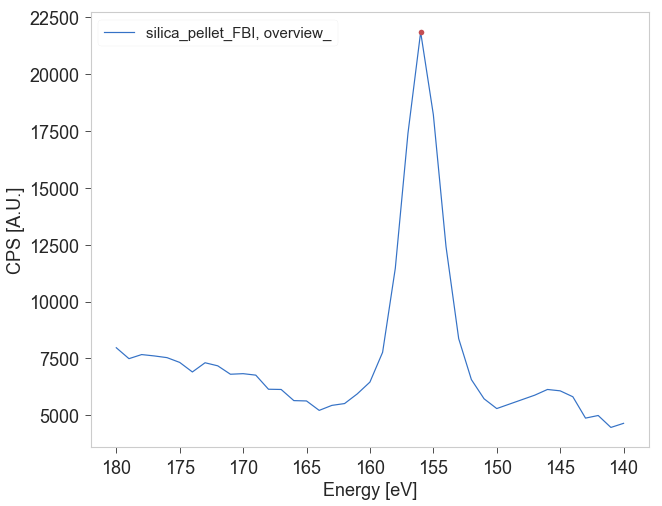

In [26]:
region = 'overview_'

plt.figure(figsize=(10,8))
trim_xp = crop_spectrum(experiments[0], region, eup=180, edw=140)
plot_region(trim_xp, region)
# find_and_plot_peaks(trim_xp.dfx[region])
df = trim_xp.dfx[region]
peaks =  peakutils.indexes(df.counts, thres=0.5, min_dist=10)
x_peaks = df.energy.values[peaks]
y_peaks = df.counts.values[peaks]
plt.plot(x_peaks, y_peaks, 'ro', label='Peaks at thres = %.1f' %0.9)

x_peaks

### Find peak energy close to Fermi level: 27 eV -> O 2s

array([27.])

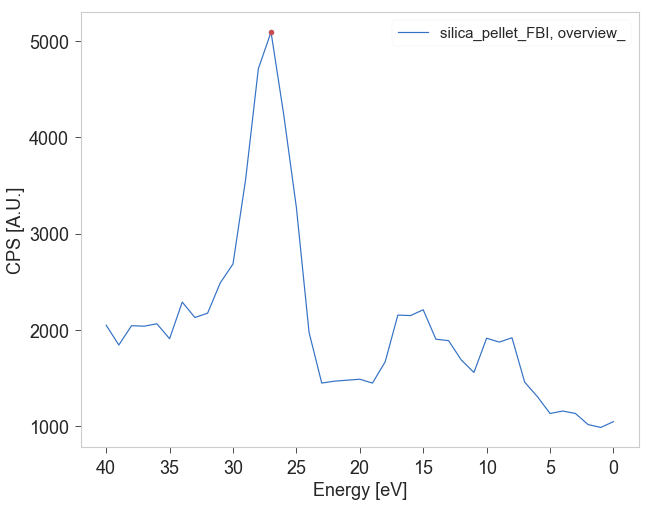

In [28]:
region = 'overview_'

plt.figure(figsize=(10,8))
trim_xp = crop_spectrum(experiments[0], region, eup=40, edw=0)
plot_region(trim_xp, region)
# find_and_plot_peaks(trim_xp.dfx[region])
df = trim_xp.dfx[region]
peaks =  peakutils.indexes(df.counts, thres=0.5, min_dist=10)
x_peaks = df.energy.values[peaks]
y_peaks = df.counts.values[peaks]
plt.plot(x_peaks, y_peaks, 'ro', label='Peaks at thres = %.1f' %0.9)

x_peaks

### Subtract double shirley to all Si 2p regions

In [26]:
[xp.dfx.columns.levels[0] for xp in experiments]

[Index(['C1s', 'N1s', 'O1s', 'Si2p', 'overview_'], dtype='object', name='range')]

### Bulk subtract background

Max iterations exceeded, subtract linear baseline


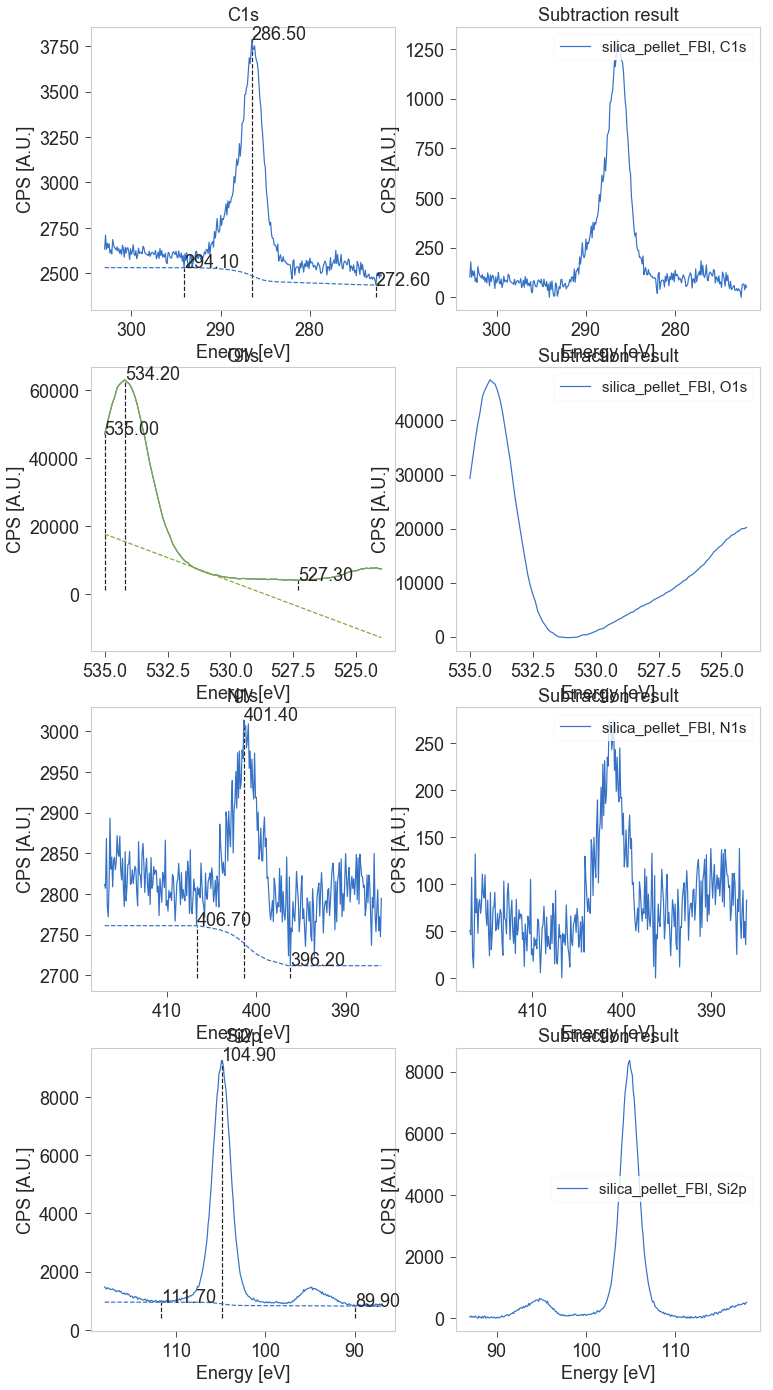

In [108]:
regions = ['C1s', 'O1s', 'N1s', 'Si2p']
bg_exps = bulk_bg_subtract(experiments, regions)

### Get O 1s from overview

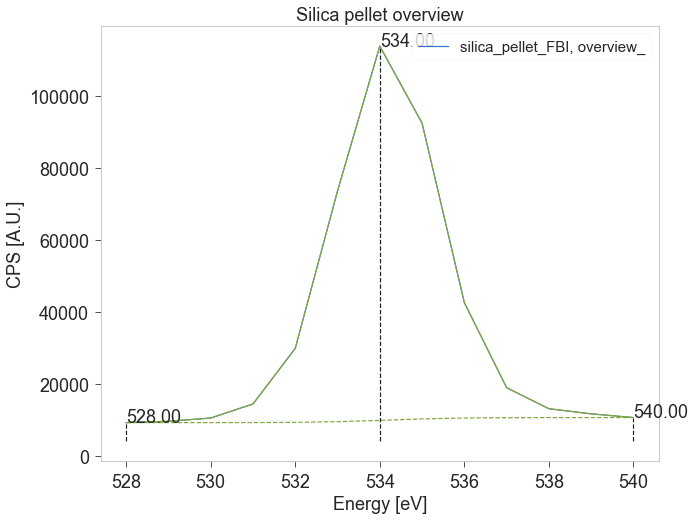

In [113]:
region = 'overview_'

plt.figure(figsize=(10,8))
trim_xp = crop_spectrum(experiments[0], region, eup=540, edw=528)
plot_region(trim_xp, 'overview_')
bgO = subtract_shirley_bg(trim_xp, region)
# plt.ylim(1.5e5, 4e5)
# cosmetics_plot()
plt.title('Silica pellet overview')

bg_exps[0].dfx['O1s'] = bgO.dfx['overview_']

## Trim regions

In [161]:
crop_exps = crop_spectrum(bg_exps[0], 'C1s', edw=282, eup=295)
crop_exps = crop_spectrum(crop_exps, 'N1s', edw=386, eup=406)
crop_exps = crop_spectrum(crop_exps, 'Si2p', edw=101, eup=110)

# Show processed regions

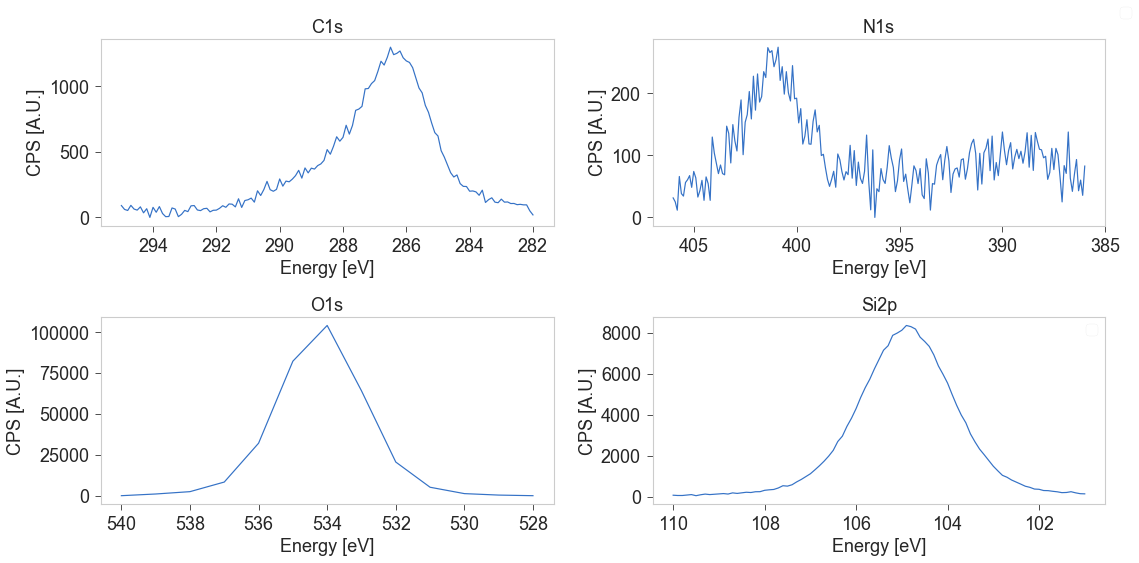

In [162]:
colors = ['b']
plot_xp_regions([crop_exps], regions, colors, ncols=2)

# Store processed spectra

In [ ]:
import os
for xp, xpProc in zip(experiments, trimmed_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)

# Area integration 

In [164]:
regions = crop_exps.dfx.columns.levels[0][:-1] 
crop_exps.area = {r:0 for r in regions}
crop_exps.area

{'C1s': 0, 'N1s': 0, 'O1s': 0, 'Si2p': 0}

In [144]:
crop_exps.area['C1s']

16085.625836245721

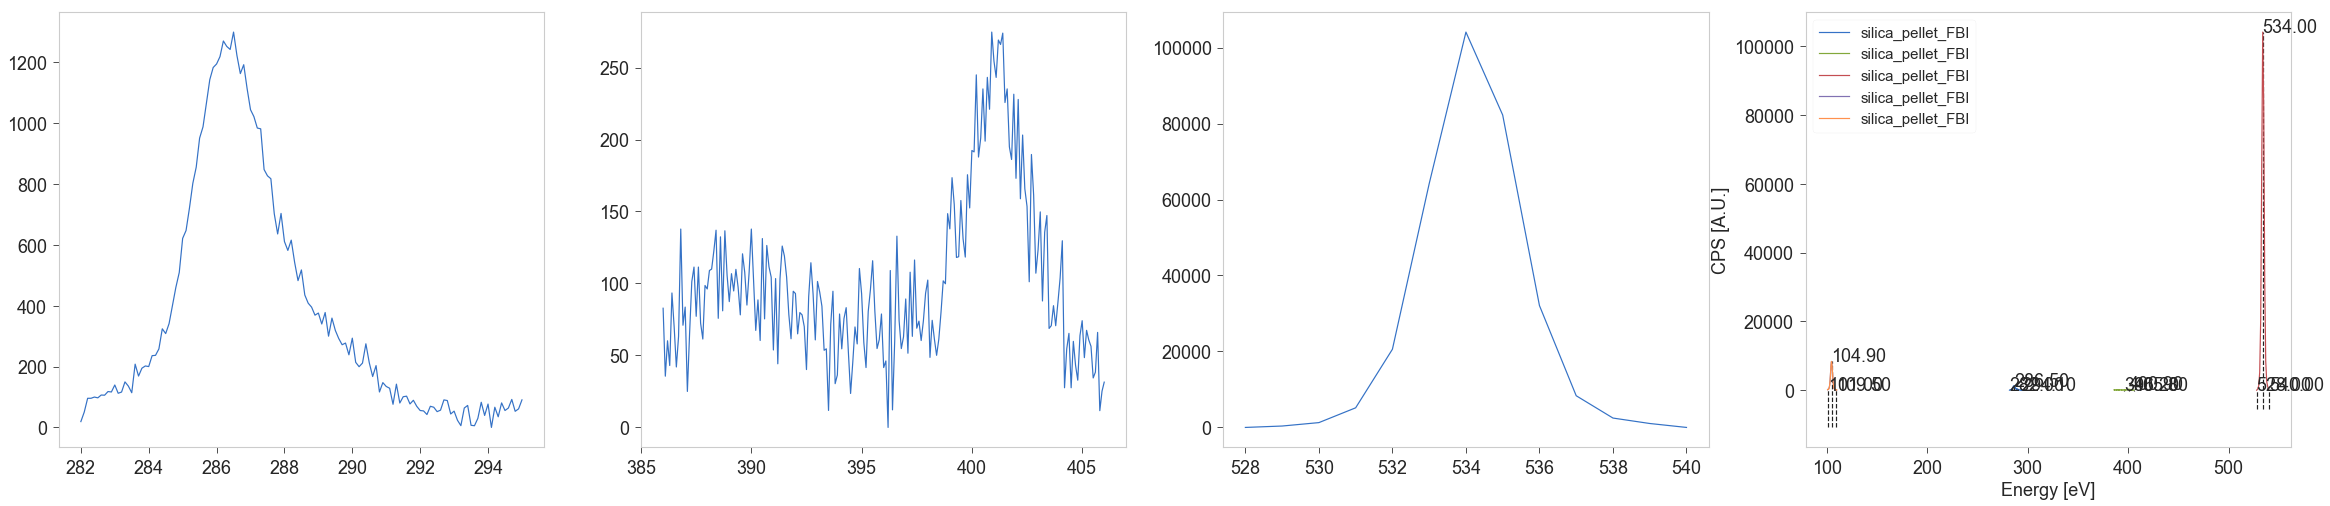

In [167]:
region = 'C1s'
fig, ax = plt.subplots(1, len(regions), figsize=(40, 8))
for i,r in enumerate(regions):
    ind = []
    for j, xp in enumerate([crop_exps]):
        ind.append(flexible_integration_limits(xp, r, doublePeak=0, flag_plot=False))

    area_rel, names = [], []
    area_in = []
    for j,xp in enumerate([crop_exps]):
        area = compare_areas(crop_exps, xp, r, lmidx=ind[0][1], rmidx=ind[0][2], ax=ax[i])
        area_rel.append(area[0])
        xp.area.update({r : area[1]/asf[r]})
        names.append(xp.name)
    # plt.xlim(805, 760)
    cosmetics_plot()
    # inset_rel_areas(area_rel, names)

# Stoichiometry 

##### Leaving both N 1s peaks

In [166]:
num, denom = (('C1s', 'N1s', 'C1s', 'O1s'), ('N1s', 'Si2p', 'O1s', 'Si2p'))
make_stoichometry_table([crop_exps],  num=num, denom=denom)

Experiment	C/N	N/Si	C/O	O/Si	
silica_pellet_FBI	6.50	 0.04	 0.04	 7.13	 


##### Leaving only one N 1s peak

In [158]:
num, denom = (('C1s', 'N1s', 'C1s', 'O1s'), ('N1s', 'Si2p', 'O1s', 'Si2p'))
make_stoichometry_table([crop_exps],  num=num, denom=denom)

Experiment	C/N	N/Si	C/O	O/Si	
silica_pellet_FBI	6.50	 0.04	 0.04	 7.13	 
